In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!p7zip -d '/content/gdrive/MyDrive/cats_dogs_dataset.7z'

/usr/bin/p7zip: cannot read /content/gdrive/MyDrive/cats_dogs_dataset.7z


In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
def preprocess_dataset(folder):
    list_data = os.listdir(folder)
    list_data.sort()
    
    images = []
    vec = []
    size = len(list_data)
    for img in list_data:
        if img.endswith('.jpg'):
            image = cv2.imread('{}/{}'.format(folder, img))
            image = cv2.resize(image, dsize=(224,224))
            images.append(image)
        else:
            with open('{}/{}'.format(folder, img), 'r') as f:
                s = f.read()
                vec.append(s)

    
    vectors = []
    for i in range(len(vec)):
        vectors.append(vec[i].split(' '))
        
    images = np.array(images)
    vectors = np.array(vectors).astype('int')
        
    vectors = np.reshape(vectors, (3385, 5))
    images = backend.cast_to_floatx(images)
    images /= 255
    
    labels = np.array([])
    coordinates = np.array([])
    for i in range(len(vectors)):
        labels = np.append(labels, vectors[i, :1])
        coordinates = np.append(coordinates, vectors[i, 1:])
    coordinates = np.reshape(coordinates, (3385, 4))

    X_train, X_test, cor_train, cor_test, lab_train, lab_test = \
                train_test_split(images, coordinates, labels, test_size=0.3, random_state=42)
    
    y_train = to_categorical(lab_train, num_classes = 3)
    y_test = to_categorical(lab_test, num_classes = 3)
    
    cordinates_train = np.interp(cor_train, [cor_train.min(), cor_train.max()], [0, 1])
    cordinates_test = np.interp(cor_test, [cor_test.min(), cor_test.max()], [0, 1])
    
    return X_train, X_test, y_train, y_test, cordinates_train, cordinates_test

In [5]:
X_train, X_test, y_train, y_test, cordinates_train, cordinates_test =\
                preprocess_dataset("cats_dogs_dataset")

In [6]:
print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((2369, 224, 224, 3), (2369, 3)) ((1016, 224, 224, 3), (1016, 3))


In [7]:
cordinates_train.shape, cordinates_test.shape

((2369, 4), (1016, 4))

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights='imagenet',
             include_top = False,
             input_shape=(224, 224, 3))
vgg16.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
def create_model(no_of_classes):
    base_model_output = vgg16.output
    flattened_output = Flatten()(base_model_output)
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction )
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction )
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax',name="class_output")(class_prediction)
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )
    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )
    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid', name= "box_output")(box_output)
    model = Model(inputs=vgg16.input, outputs= [box_predictions, class_prediction])
    return model

model = create_model(3)

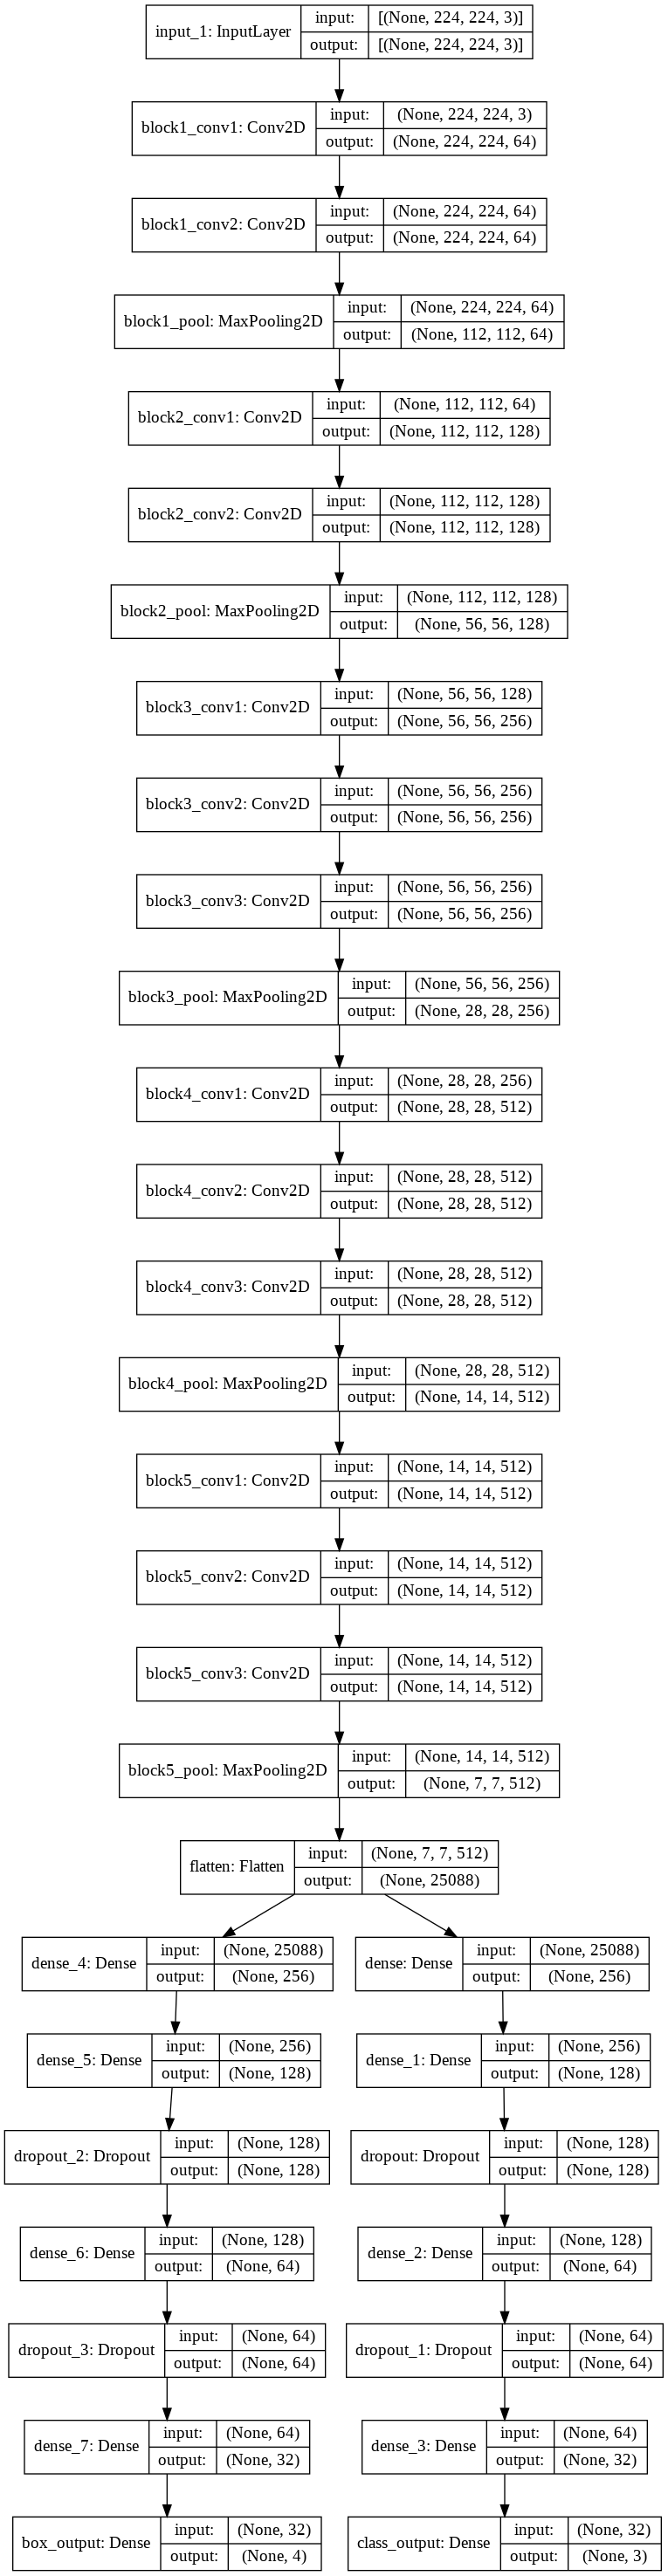

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

losses = {
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }
loss_weights = {
    "box_output": 1.0,
    "class_output": 1.0
    }
metrics = {
    'class_output': 'accuracy',
    'box_output':  'mse'
    }
stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40,restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002,  patience = 30, min_lr = 1e-7, verbose = 1)
opt = SGD(lr = 1e-3, momentum = 0.9)
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, metrics = metrics)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
history = model.fit(x = X_train,
                    y= {
                        "box_output": cordinates_train,
                        "class_output": y_train
                        },
                    validation_data=(
                        X_test,
                        {
                          "box_output": cordinates_test,
                          "class_output": y_test
                          }), batch_size = 64, epochs = 300,
                    callbacks=[reduce_lr, stop])

Epoch 1/300
38/38 [==============================] - 61s 593ms/step - loss: 0.7652 - box_output_loss: 0.0761 - class_output_loss: 0.6891 - box_output_mse: 0.0761 - class_output_accuracy: 0.6724 - val_loss: 0.5821 - val_box_output_loss: 0.0064 - val_class_output_loss: 0.5757 - val_box_output_mse: 0.0064 - val_class_output_accuracy: 0.6919
Epoch 2/300
38/38 [==============================] - 13s 344ms/step - loss: 0.5613 - box_output_loss: 0.0067 - class_output_loss: 0.5546 - box_output_mse: 0.0067 - class_output_accuracy: 0.7222 - val_loss: 0.5130 - val_box_output_loss: 0.0103 - val_class_output_loss: 0.5027 - val_box_output_mse: 0.0103 - val_class_output_accuracy: 0.6998
Epoch 3/300
38/38 [==============================] - 13s 344ms/step - loss: 0.4189 - box_output_loss: 0.0051 - class_output_loss: 0.4137 - box_output_mse: 0.0051 - class_output_accuracy: 0.8138 - val_loss: 0.6740 - val_box_output_loss: 0.0109 - val_class_output_loss: 0.6631 - val_box_output_mse: 0.0109 - val_class_outp

In [15]:
def plot(var1, var2, plot_name):
  c1 = history.history[var1]
  c2 = history.history[var2]
  epochs = range(len(c1))
  plt.plot(epochs, c1, 'b', label=var1)
  plt.plot(epochs, c2, 'r', label=var2)
  plt.title(str(plot_name))
  plt.legend()


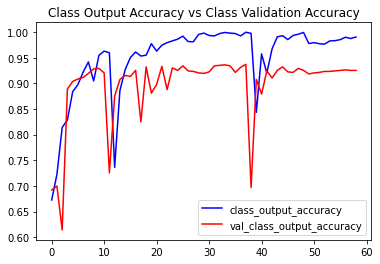

In [16]:
plot( 'class_output_accuracy', 'val_class_output_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')

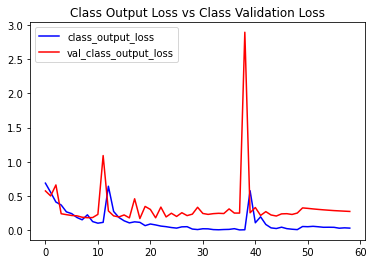

In [17]:
plot( 'class_output_loss', 'val_class_output_loss', 'Class Output Loss vs Class Validation Loss')

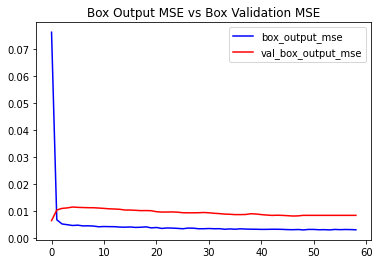

In [18]:
	plot( 'box_output_mse', 'val_box_output_mse', 'Box Output MSE vs Box Validation MSE')

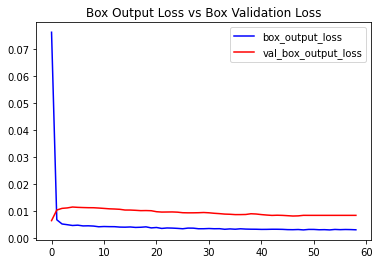

In [19]:
plot('box_output_loss', 'val_box_output_loss', 'Box Output Loss vs Box Validation Loss')